In [1]:
!pip install xgboost

In [3]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import xgboost as xgb  # For the XGBoost algorithm
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and hyperparameter tuning
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # For model evaluation
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting graphs


In [13]:
import pandas as pd

# Load data from CSV files
github_data = pd.read_csv('github.csv')  # Replace with the actual path to your GitHub CSV
stackoverflow_data = pd.read_csv('stackoverflow.csv')  # Replace with the actual path to your Stack Overflow CSV

# Display the first few rows of GitHub data
print(github_data.head())

# Display the first few rows of Stack Overflow data
print(stackoverflow_data.head())



        username  followers  following  public_repos  public_gists  hireable  \
0           a1cd          9         33            69             4       NaN   
1  AaronBertrand         48          0            16             0       NaN   
2     aaronchall        113         28            62            13       NaN   
3       abarnert         33          0           112             6       NaN   
4      abdennour        254          6           216            79      10.0   

                                                 bio       location  \
0                                                NaN            NaN   
1  Long-time Microsoft Data Platform MVP, occasio...   Matthews, NC   
2                                                NaN  Manhattan, NY   
3                                                NaN  San Francisco   
4  Former full stack developer, switched to the d...        Tunisia   

            company                 email           created_at  \
0  DARC SIDE | 6502       

In [ ]:
# import pandas as pd
# from __init__ import path
# path()
# from connection.db_connection import get_sqlalchemy_engine

# # Get SQLAlchemy engine and database name
# engine, DB_NAME = get_sqlalchemy_engine()

# # Fetch data from 'github' table
# query_github = "SELECT * FROM github_fetch"
# github_data = pd.read_sql(query_github, engine)

# # Fetch data from 'stackoverflow' table
# query_stackoverflow = "SELECT * FROM stackoverflow_fetch"
# stackoverflow_data = pd.read_sql(query_stackoverflow, engine)

In [14]:
# Extracting the username from the githubUrl in Stack Overflow data
stackoverflow_data['username'] = stackoverflow_data['githubUrl'].apply(
    lambda url: url.split('/')[-1] if isinstance(url, str) else None
)

# Perform the join on the 'username' column
merged_data = pd.merge(stackoverflow_data, github_data, on='username', how='inner')

# Display the first few rows of the merged dataset
print(merged_data.head())

# Select the relevant features
selected_features = ['reputation', 'answers', 'questions', 'gold_badge_score', 
                     'silver_badge_score', 'bronze_badge_score', 'total_stars', 
                     'total_forks', 'total_contributions', 'commit_count', 
                     'pull_request_count', 'issue_count']

# Check for missing values
missing_values = merged_data[selected_features].isnull().sum()
print("Missing values in selected features:\n", missing_values)

# Check the number of rows and columns in the dataframe
rows, columns = merged_data.shape
print(f"The merged dataset has {rows} rows and {columns} columns.")


   id                                         profileURL  user_id  \
0   1  https://stackoverflow.com/users/100297/martijn...   100297   
1   2    https://stackoverflow.com/users/5133585/sweeper  5133585   
2   3    https://stackoverflow.com/users/22656/jon-skeet    22656   
3   4  https://stackoverflow.com/users/65863/remy-lebeau    65863   
4   5    https://stackoverflow.com/users/45375/mklement0    45375   

                       githubUrl  reputation    reached  answers  questions  \
0   https://github.com/mjpieters     1105781  173600000    19919          3   
1  https://github.com/Sweeper777      254850    7200000     7545        286   
2      https://github.com/jskeet     1481113  412200000    35740         55   
3     https://github.com/rlebeau      585169   34400000    17160          6   
4   https://github.com/mklement0      424730   55000000     8168         24   

   gold_badge_score  silver_badge_score  ...           created_at  \
0               316                4179  

In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the selected features
scaled_features = scaler.fit_transform(merged_data[selected_features])

# Convert the scaled features back into a DataFrame for easier analysis
scaled_df = pd.DataFrame(scaled_features, columns=selected_features)

# Display the first few rows of the scaled data
print(scaled_df.head())


   reputation   answers  questions  gold_badge_score  silver_badge_score  \
0    4.727826  4.585455  -0.549686          4.266871            6.917494   
1    0.350591  1.278775   1.390876         -0.400147           -0.227867   
2    6.658554  8.813269  -0.193116         13.266413           16.078075   
3    2.049769  3.848173  -0.529114         -0.256792            0.250657   
4    1.224463  1.445258  -0.405686          0.316630            0.608196   

   bronze_badge_score  total_stars  total_forks  total_contributions  \
0            5.381079     0.064736    -0.097640            -0.132915   
1           -0.089680    -0.235206    -0.218873            -0.129722   
2           15.867294     0.071236     0.278821             0.295925   
3            0.740576    -0.240313    -0.221000            -0.389475   
4            0.851276     0.624225     0.017213            -0.167957   

   commit_count  pull_request_count  issue_count  
0      1.404472            0.636776     0.469855  
1      1

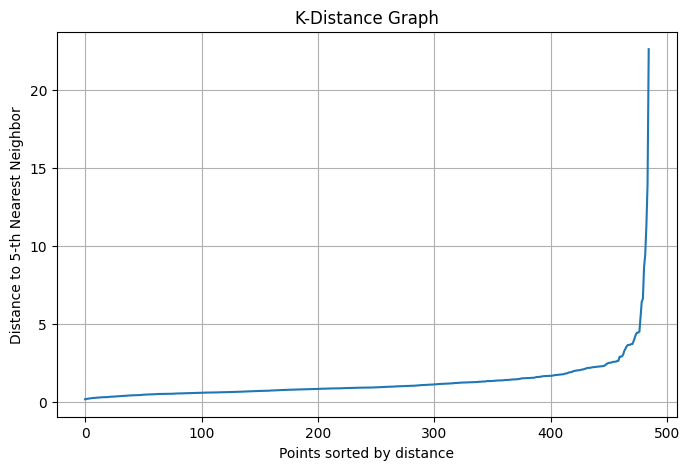

dbscan_cluster
 0    480
-1      5
Name: count, dtype: int64
     username  dbscan_cluster
0   mjpieters               0
1  Sweeper777               0
2      jskeet              -1
3     rlebeau               0
4   mklement0               0


In [53]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Calculate the distance to the k-th nearest neighbor
k = 5  # You can use the same value as min_samples or adjust as needed
nbrs = NearestNeighbors(n_neighbors=k).fit(scaled_df)
distances, indices = nbrs.kneighbors(scaled_df)

# Sort the distances to plot
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to {}-th Nearest Neighbor'.format(k))
plt.grid()
plt.show()

# Based on the K-Distance Graph, set the eps value
eps_value = 5  # Adjust based on the graph

# Initialize DBSCAN with the chosen parameters
dbscan = DBSCAN(eps=eps_value, min_samples=5)  # min_samples can also be adjusted
dbscan.fit(scaled_df)

# Assign cluster labels to each user (outliers will be labeled as -1)
merged_data['dbscan_cluster'] = dbscan.labels_

# Display the number of users in each cluster (-1 means outliers)
print(merged_data['dbscan_cluster'].value_counts())

# Display the first few rows with the cluster labels
print(merged_data[['username', 'dbscan_cluster']].head())


In [54]:
# Check the number of users in each cluster
cluster_counts = merged_data['dbscan_cluster'].value_counts()
print(cluster_counts)

# Display the first few rows with the cluster labels
print(merged_data[['username', 'dbscan_cluster']].head(20))


dbscan_cluster
 0    480
-1      5
Name: count, dtype: int64
            username  dbscan_cluster
0          mjpieters               0
1         Sweeper777               0
2             jskeet              -1
3            rlebeau               0
4          mklement0               0
5   gabrielemariotti               0
6           ghewgill               0
7          hashpling               0
8      basil-bourque               0
9         shepmaster               0
10      cirosantilli               0
11         tjcrowder               0
12            bergus               0
13           laurenz               0
14            larsks               0
15          trekonom               0
16         gurustron               0
17            zoechi               0
18          wimglenn               0
19          mattneub               0


In [55]:
# First, select only the numeric columns
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Group by the 'dbscan_cluster' and calculate the mean for the numeric columns
cluster_summary = merged_data.groupby('dbscan_cluster')[numeric_columns].mean()

# Display the cluster summary
print(cluster_summary)


                        id       user_id     reputation       reached  \
dbscan_cluster                                                          
-1              188.000000  8.848198e+05  578992.800000  1.151400e+08   
 0              263.452083  2.946872e+06  182609.047917  2.364682e+07   

                answers  questions  gold_badge_score  silver_badge_score  \
dbscan_cluster                                                             
-1              12519.6     72.400         239.20000         2566.400000   
 0               2658.0     83.275          46.13125          325.083333   

                bronze_badge_score    followers  ...  public_gists  hireable  \
dbscan_cluster                                   ...                           
-1                         2580.20  3751.800000  ...     33.200000       NaN   
 0                          380.55   312.004167  ...     27.564583      10.0   

                total_stars  total_forks  total_contributions  total_repos  \
dbs

In [61]:
# Label suitable candidates based on cluster analysis
merged_data['suitable_candidate'] = merged_data['dbscan_cluster'].apply(
    lambda x: 'Highly Suitable' if x == 0 else 'Not Suitable' 
)

# Display the result
print(merged_data[['username', 'dbscan_cluster', 'suitable_candidate']].head(20))  # Show more rows if needed


            username  dbscan_cluster suitable_candidate
0          mjpieters               0    Highly Suitable
1         Sweeper777               0    Highly Suitable
2             jskeet              -1       Not Suitable
3            rlebeau               0    Highly Suitable
4          mklement0               0    Highly Suitable
5   gabrielemariotti               0    Highly Suitable
6           ghewgill               0    Highly Suitable
7          hashpling               0    Highly Suitable
8      basil-bourque               0    Highly Suitable
9         shepmaster               0    Highly Suitable
10      cirosantilli               0    Highly Suitable
11         tjcrowder               0    Highly Suitable
12            bergus               0    Highly Suitable
13           laurenz               0    Highly Suitable
14            larsks               0    Highly Suitable
15          trekonom               0    Highly Suitable
16         gurustron               0    Highly S

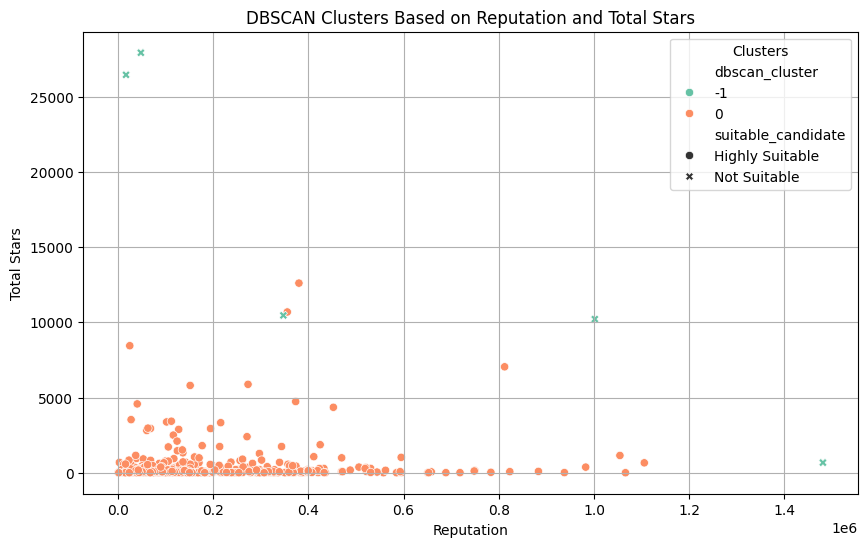

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the clusters using two key features, such as 'reputation' and 'total_stars'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_data['reputation'], 
                 y=merged_data['total_stars'], 
                 hue=merged_data['dbscan_cluster'], 
                 palette='Set2', 
                 style=merged_data['suitable_candidate'],
                 markers={'Highly Suitable': 'o', 'Not Suitable': 'X'})

plt.title('DBSCAN Clusters Based on Reputation and Total Stars')
plt.xlabel('Reputation')
plt.ylabel('Total Stars')
plt.legend(title='Clusters')
plt.grid()
plt.show()


In [64]:
# Count the number of candidates in each category
candidate_counts = merged_data['suitable_candidate'].value_counts()

# Display the counts
print(candidate_counts)


suitable_candidate
Highly Suitable    480
Not Suitable         5
Name: count, dtype: int64


In [65]:
# Create a numeric target variable based on suitable candidates
merged_data['suitable_candidate_numeric'] = merged_data['suitable_candidate'].apply(
    lambda x: 1 if x == 'Highly Suitable' else 0
)

# Define features and target variable
selected_features = ['reputation', 'answers', 'questions', 'gold_badge_score', 
                     'silver_badge_score', 'bronze_badge_score', 'total_stars', 
                     'total_forks', 'total_contributions', 'commit_count', 
                     'pull_request_count', 'issue_count']

X = merged_data[selected_features]
y = merged_data['suitable_candidate_numeric']  # Target variable

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (for example, XGBoost)
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        96

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97



/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:01:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [66]:
# Define the selected features
selected_features = ['reputation', 'answers', 'questions', 'gold_badge_score', 
                     'silver_badge_score', 'bronze_badge_score', 'total_stars', 
                     'total_forks', 'total_contributions', 'commit_count', 
                     'pull_request_count', 'issue_count']

# Select only highly suitable candidates
highly_suitable_candidates = merged_data[merged_data['suitable_candidate'] == 'Highly Suitable']

# Calculate a composite score for each candidate (average of the selected features)
highly_suitable_candidates['composite_score'] = highly_suitable_candidates[selected_features].mean(axis=1)

# Display the candidates with their scores
print(highly_suitable_candidates[['username', 'composite_score'] + selected_features].head(20))


            username  composite_score  reputation  answers  questions  \
0          mjpieters    148925.583333     1105781    19919          3   
1         Sweeper777     77006.583333      254850     7545        286   
3            rlebeau     50306.250000      585169    17160          6   
4          mklement0     83355.583333      424730     8168         24   
5   gabrielemariotti     47605.416667      355723     3526         17   
6           ghewgill     88084.166667      982632     5384         55   
7          hashpling    111045.333333      783439     1979          0   
8      basil-bourque     52659.916667      329938     6529        487   
9         shepmaster     41265.500000      422305     3206        100   
10      cirosantilli     79183.833333      373851     1811        164   
11         tjcrowder     91098.416667     1066245    22735         95   
12            bergus     80971.416667      658218    12578         37   
13           laurenz     20890.083333      237232  

/var/folders/_x/fv2v2nbs39j3cbx9h0t6w8100000gn/T/ipykernel_15309/507335136.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highly_suitable_candidates['composite_score'] = highly_suitable_candidates[selected_features].mean(axis=1)


In [67]:
# Determine the threshold for the top x% of candidates based on the composite score
score_threshold = highly_suitable_candidates['composite_score'].quantile(0.90)  # 90th percentile

# Filter candidates who meet or exceed the composite score threshold
top_candidates = highly_suitable_candidates[highly_suitable_candidates['composite_score'] >= score_threshold]

# Display the selected top candidates
print(top_candidates[['username', 'composite_score'] + selected_features])


                    username  composite_score  reputation  answers  questions  \
15                  trekonom     2.771742e+05      117661     4522          3   
16                 gurustron     3.808392e+05      134697     4138          3   
20                  smarnach     1.940843e+05      595574     2589         12   
24                   dorward     1.831623e+05      937898    24732          4   
28                   pcordes     2.228387e+05      353803     6500         28   
37               daiplusplus     1.742277e+06      152565     3983        339   
39                 Coldsp33d     2.592158e+05      398497     5646        154   
46                     SLaks     2.642421e+05      883354    15099         51   
50   ImportanceOfBeingErnest     2.864766e+05      335688     5153         15   
54                IISResetMe     8.406846e+05      171492     4619          9   
58                      poke     2.849452e+05      383700     3518         82   
65             StephenCleary

In [68]:
from sklearn.cluster import DBSCAN

# Define your eps and min_samples
eps_value = 5  # Example value, adjust as necessary
min_samples_value = 5  # Example value, adjust as necessary

# Initialize DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)

# Fit DBSCAN model on the scaled features
dbscan.fit(scaled_df)

# Assign cluster labels to each user (outliers will be labeled as -1)
merged_data['dbscan_cluster'] = dbscan.labels_

# Check the number of users in each cluster
cluster_counts = merged_data['dbscan_cluster'].value_counts()
print(cluster_counts)


dbscan_cluster
 0    480
-1      5
Name: count, dtype: int64


In [69]:
import pandas as pd

# Assuming 'merged_data' is your DataFrame after DBSCAN

# Create a numeric target variable based on dbscan_cluster
merged_data['suitable_candidate_numeric'] = merged_data['dbscan_cluster'].apply(
    lambda x: 1 if x == 0 else 0  # Cluster 0 is considered suitable
)

# Define the features to use for the model
selected_features = ['reputation', 'answers', 'questions', 'gold_badge_score', 
                     'silver_badge_score', 'bronze_badge_score', 'total_stars', 
                     'total_forks', 'total_contributions', 'commit_count', 
                     'pull_request_count', 'issue_count']

# Create feature matrix (X) and target vector (y)
X = merged_data[selected_features]  # Features
y = merged_data['suitable_candidate_numeric']  # Target variable

# Display the first few rows of X and y to ensure they are correct
print(X.head())
print(y.head())


   reputation  answers  questions  gold_badge_score  silver_badge_score  \
0     1105781    19919          3               316                4179   
1      254850     7545        286                23                 222   
2     1481113    35740         55               881                9252   
3      585169    17160          6                32                 487   
4      424730     8168         24                68                 685   

   bronze_badge_score  total_stars  total_forks  total_contributions  \
0                3417          658           58               651832   
1                 353           12            1               659944   
2                9290          672          235              1741368   
3                 818            1            0                    1   
4                 880         1863          112               562802   

   commit_count  pull_request_count  issue_count  
0           802                  68           74  
1           81

In [120]:
from sklearn.model_selection import train_test_split

# Assuming merged_data is your DataFrame
X = merged_data[selected_features]  # Replace selected_features with your actual features
y = merged_data['suitable_candidate_numeric']  # Your target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [122]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with a lower n_neighbors value
smote = SMOTE(random_state=42, k_neighbors=3)  # Set to 3 or lower than your minority class size

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# You can also calculate class weights, but since we're using SMOTE, we may skip that
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


In [144]:
from xgboost import XGBClassifier

# Create the model with class weights
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Adjust class weights
)

# Fit the model
model.fit(X_train, y_train)


/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:17:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [145]:
model.fit(X_resampled, y_resampled)


/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:17:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [146]:

# Step 1: Make Predictions
y_pred = model.predict(X_test)

# Step 2: Convert predictions to DataFrame
predicted_df = pd.DataFrame(y_pred, columns=['suitable_candidate_numeric'])
results_df = pd.concat([merged_data[['username']], predicted_df], axis=1)

# Step 3: Map Numeric Predictions to Categorical Labels
results_df['suitable_candidate'] = results_df['suitable_candidate_numeric'].apply(
    lambda x: 'Highly Suitable' if x == 1 else 'Not Suitable'
)

# Step 4: Count Suitable Candidates
suitable_counts = results_df['suitable_candidate'].value_counts()
print(suitable_counts)


suitable_candidate
Not Suitable       400
Highly Suitable     85
Name: count, dtype: int64


In [147]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.8865979381443299
              precision    recall  f1-score   support

           0       0.08      1.00      0.15         1
           1       1.00      0.89      0.94        96

    accuracy                           0.89        97
   macro avg       0.54      0.94      0.55        97
weighted avg       0.99      0.89      0.93        97



<Figure size 1000x600 with 0 Axes>

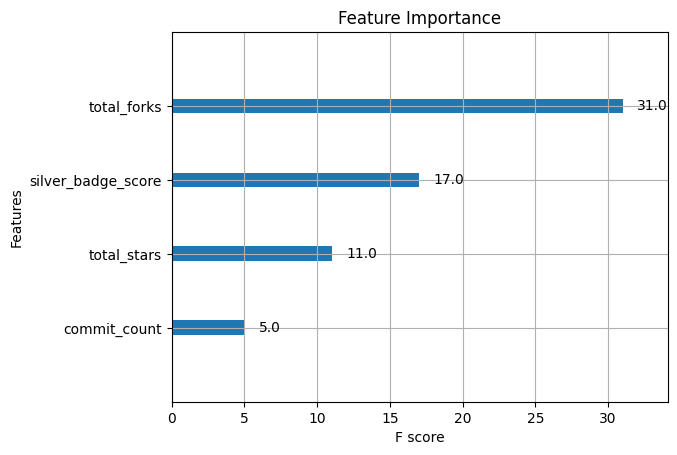

In [148]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()


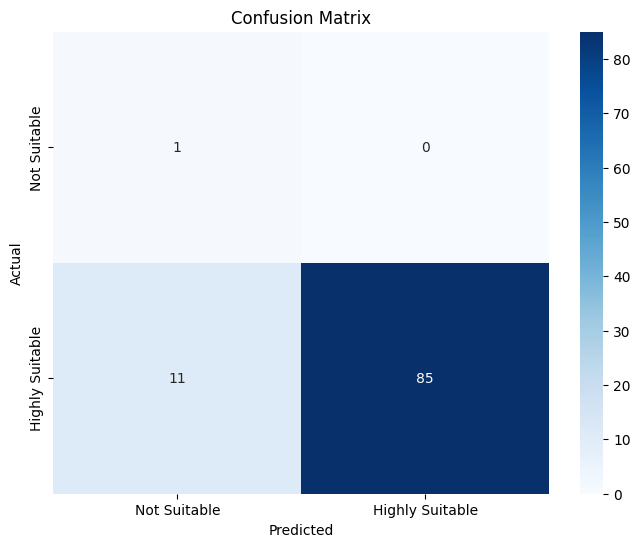

In [150]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have trained your model and have X_test available
final_y_pred = model.predict(X_test)  # Replace 'model' with your actual model variable

# Generate the confusion matrix
cm = confusion_matrix(y_test, final_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Not Suitable", "Highly Suitable"], 
            yticklabels=["Not Suitable", "Highly Suitable"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [151]:
from sklearn.metrics import classification_report

# Generate and display the classification report
print(classification_report(y_test, final_y_pred))


              precision    recall  f1-score   support

           0       0.08      1.00      0.15         1
           1       1.00      0.89      0.94        96

    accuracy                           0.89        97
   macro avg       0.54      0.94      0.55        97
weighted avg       0.99      0.89      0.93        97

